# Setting up and running AimqbCalculations

The simplest use of `aiida-aimall` is in running `AIMQB` calculation jobs. This class can be found in `aiida-aimall.calculations`. Input for these calculations is simple and straightforward. Inputs that are required are
 - parameters (`AimqbParameters`)
 - file (`SinglefileData`)
 - code (`Code`)
 - metadata.resources (`dict`)

There are two other inputs (`group_atoms` and `attached_atom_int`) that are required for using the `AimqbGroupParser` to compute group properties, but are not in use here in the default. Those will be explained in another tutorial.

The `AimqbParameters` input can be generated following instructions in other tutorials. The `SinglefileData` input can either be created from an absolute path to the file, or by providing the file as a string.

 ```python
from aiida.orm import SinglefileData
import io

input_file = SinglefileData('/absolute/path/to/file')

input_file = SinglefileData('io.BytesIO(wfx_file_string.encode())')
```

In [8]:
from aiida import load_profile
from aiida.orm import load_node,load_code
from aiida.plugins import DataFactory, CalculationFactory
from aiida.engine import submit

load_profile()

# create inputs
AimqbParameters = DataFactory('aimall.aimqb')
AimqbCalculation = CalculationFactory('aimall.aimqb')

# this is a previously available wfx file node in the AiiDA profile
input_file = load_node('b6710cfe')
aim_code = load_code('aimall@localhost')
aim_input = AimqbParameters({'nproc':2,'naat':2,'atlaprhocps':True})

# add inputs to the builder
builder = AimqbCalculation.get_builder()
builder.parameters = aim_input
builder.file = input_file
builder.code = aim_code
# tot_num_mpiprocs should match nproc from aim_input
builder.metadata.options.resources = {"num_machines": 1, "tot_num_mpiprocs": 2}
node = submit(builder)

We can view the provenance graph to see what the inputs and outputs of this calculation look like.

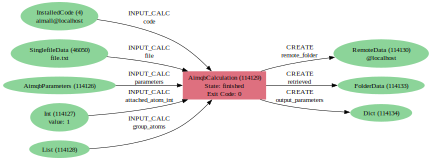

In [11]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph.add_incoming(node.uuid,
                   annotate_links="both")
graph.add_outgoing(node.uuid,
                   annotate_links="both")
graph.graphviz

The retrieved node is of type `FolderData`, by default only containing the output .sum file from the AIMQB calculation. The other main output node of interest is the `output_parameters` node. This node is a `Dict` object, with keys for the Localisation-Delocalization matrix of Matta (ldm), atomic properties for all atoms in the molecule (atomic_properties), all bond critical point properties (bcp_properties), and, if `atlaprhocps` was true in `aim_input`, a dictionary containing all valence shell charge concentrations (cc_properties). atomic_properties and cc_properties have keys corresponding to the labels of all atoms in the molecule. bcp_properties keys are all pairs of bonded atoms of format A1-B2 for atoms A1 and B2, for example.

In [20]:
retrieved_node = load_node(114133)
print('Retrieved node contents')
print(retrieved_node.list_object_names())


output_node = load_node(114134)
output_dict = output_node.get_dict()
print('Output dictionary keys')
print(output_dict.keys())
print('Atomic Property Keys')
print(output_dict['atomic_properties'].keys())
print('BCP Property Keys')
print(output_dict['bcp_properties'].keys())
print('CC Property Keys')
print(output_dict['cc_properties'].keys())


Retrieved node contents
['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'aiida.sum', 'aiida_atomicfiles']
Output dictionary keys
dict_keys(['ldm', 'cc_properties', 'bcp_properties', 'atomic_properties'])
Atomic Property Keys
dict_keys(['C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'H2', 'O9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18'])
BCP Property Keys
dict_keys(['C1-H2', 'C3-C1', 'C3-O9', 'C4-C3', 'C5-C4', 'C6-C5', 'C6-C7', 'C7-C8', 'C8-O9', 'C8-H17', 'C8-H18', 'H10-C1', 'H11-C4', 'H12-C4', 'H13-C5', 'H14-C6', 'H15-C7', 'H16-C7'])
CC Property Keys
dict_keys(['C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'H2', 'O9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18'])


Each of these dictionaries of atom labels or atom label pairs are further dictionaries containing the extracted properties of the given type. Using these keys will then give you the requested property.

In [24]:
print('Extracted Atomic Properties')
print(output_dict['atomic_properties']['C1'].keys())
print('BCP Property Keys')
print(output_dict['bcp_properties']['C1-H2'].keys())
print('CC Property Keys')
print(output_dict['cc_properties']['O9'].keys())

Extracted Atomic Properties
dict_keys(['K', 'q', 'R+1', 'R+2', 'Vol', 'xyz', 'Mu_X', 'Mu_Y', 'Mu_Z', 'Q_XX', 'Q_XY', 'Q_XZ', 'Q_YY', 'Q_YZ', 'Q_ZZ', '|Mu|', 'K_Scaled', 'Mu_Bond_X', 'Mu_Bond_Y', 'Mu_Bond_Z', '|Mu_Bond|', 'Mu_Intra_X', 'Mu_Intra_Y', 'Mu_Intra_Z', '|Mu_Intra|', 'quadContrib'])
BCP Property Keys
dict_keys(['G', 'H', 'V', 'rho', 'xyz', 'lambda1', 'lambda2', 'lambda3', 'DelSqRho', 'Ellipticity'])
CC Property Keys
dict_keys(['4', '5'])
